<a href="https://colab.research.google.com/github/almutareb/rag-based-llm-app/blob/main/Mistral_7b_RAG%2BFAISS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Process Flow

1. Initialize model pipeline: initializing text-generation pipeline with Hugging Face transformers for the pretrained Mistral-7B-Instruct-v0.1 model.

2. Ingest data: loading the data from arbitrary sources in the form of text into the document loader.

3. Split into chunks: splitting the loaded text into smaller chunks. It is necessary to create small chunks of text because language models can handle limited amount of text.

4. Create embeddings: converting the chunks of text into numerical values, also known as embeddings. These embeddings are used to search and retrieve similar or relevant documents quickly in large databases, as they represent the semantic meaning of the text.

5. Load embeddings into vector store: loading the embeddings into a vector store i.e. “FAISS” in this case. Vector stores perform extremely well in similarity search using text embeddings compared to the traditional databases.

6. Enable memory: combing chat history with a new question and turn them into a single standalone question is quite important to enable the ability to ask follow up questions.

7. Query data: searching for the relevant information stored in vector store using the embeddings.

8. Generate answer: passing the standalone question and the relevant information to the question-answering chain where the language model is used to generate an answer.

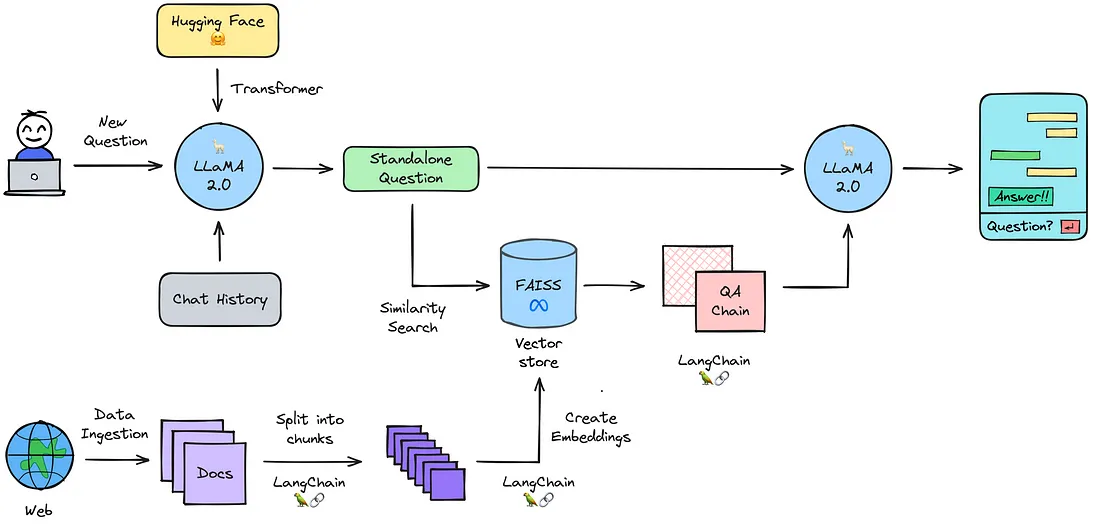

In [ ]:
# install needed packages
!pip install -qU transformers accelerate einops langchain xformers bitsandbytes faiss-gpu sentence_transformers typing-extensions==4.8.0

In [ ]:
from torch import cuda, bfloat16
import transformers

model_id = 'mistralai/Mistral-7B-Instruct-v0.1'

device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

# set quantization configuration to load large model with less GPU memory
# this requires the 'bitsandbytes' library
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=bfloat16
)

# begin initializing model
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map='auto',
)

# enable evaluation mode to allow model inference
model.eval()

print(f"Model loaded on {device}")


In [ ]:
# Define stop tokens to controll output
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

stop_list = ['\nHuman:', '\n```\n']

stop_token_ids = [tokenizer(x)['input_ids'] for x in stop_list]
stop_token_ids

In [ ]:
# convert the stop token ids into LongTensor
import torch

stop_token_ids = [torch.LongTensor(x).to(device) for x in stop_token_ids]
stop_token_ids

In [6]:
from transformers import StoppingCriteria, StoppingCriteriaList

# define custom stopping criteria object
class StopOnTokens(StoppingCriteria):
  def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
    for stop_ids in stop_token_ids:
      if torch.eq(input_ids[0][-len(stop_ids):], stop_ids).all():
        return True
    return False
stopping_criteria = StoppingCriteriaList([StopOnTokens()])

In [7]:
# initialize a text-generation transformer pipeline
generate_text = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    return_full_text=True,
    task='text-generation',
    stopping_criteria=stopping_criteria,
    #temperature=0.1,
    max_new_tokens=512,
    repetition_penalty=1.1
)

In [9]:
# test inference directly
res = generate_text("Explain to me the difference between Data Lakehouse and Data Warehouse")
print(res[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Explain to me the difference between Data Lakehouse and Data Warehouse.
Data lakehouse is a type of data warehouse that stores all types of data, including structured, unstructured, semi-structured, and multi-structured data. It allows for easy access to data from various sources and provides a centralized location for storing and analyzing data.
On the other hand, a traditional data warehouse typically stores only structured data in a predefined schema. It is optimized for querying and reporting on historical data and may not be as flexible as a data lakehouse when it comes to handling new types of data or changing business requirements.
In summary, a data lakehouse is a more flexible and scalable approach to data storage and analysis, while a traditional data warehouse is more focused on structured data and historical reporting.


In [8]:
# now with a HF pipeline
from langchain.llms import HuggingFacePipeline

llm = HuggingFacePipeline(pipeline=generate_text)

llm(prompt="Explain to me the difference between Data Lakehouse and Data Warehouse")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'.\nData lakehouse is a type of data warehouse that stores all types of data, including structured, unstructured, semi-structured, and multi-structured data. It allows for easy access to data from various sources and provides a centralized location for storing and analyzing data.\nOn the other hand, a traditional data warehouse typically stores only structured data in a predefined schema. It is optimized for querying and reporting on historical data and may not be as flexible as a data lakehouse when it comes to handling new types of data or changing business requirements.\nIn summary, a data lakehouse is a more flexible and scalable approach to data storage and analysis, while a traditional data warehouse is more focused on structured data and historical reporting.'

## initial test with WebBaseLoader and a list of URLs

In [ ]:
# we will use WebBaseLoader to load HTML documents
# trying recursive url loader instead now

# from langchain.document_loaders import WebBaseLoader

#web_links = ["https://www.databricks.com/","https://help.databricks.com","https://databricks.com/try-databricks","https://help.databricks.com/s/","https://docs.databricks.com","https://kb.databricks.com/","http://docs.databricks.com/getting-started/index.html","http://docs.databricks.com/introduction/index.html","http://docs.databricks.com/getting-started/tutorials/index.html","http://docs.databricks.com/release-notes/index.html","http://docs.databricks.com/ingestion/index.html","http://docs.databricks.com/exploratory-data-analysis/index.html","http://docs.databricks.com/data-preparation/index.html","http://docs.databricks.com/data-sharing/index.html","http://docs.databricks.com/marketplace/index.html","http://docs.databricks.com/workspace-index.html","http://docs.databricks.com/machine-learning/index.html","http://docs.databricks.com/sql/index.html","http://docs.databricks.com/delta/index.html","http://docs.databricks.com/dev-tools/index.html","http://docs.databricks.com/integrations/index.html","http://docs.databricks.com/administration-guide/index.html","http://docs.databricks.com/security/index.html","http://docs.databricks.com/data-governance/index.html","http://docs.databricks.com/lakehouse-architecture/index.html","http://docs.databricks.com/reference/api.html","http://docs.databricks.com/resources/index.html","http://docs.databricks.com/whats-coming.html","http://docs.databricks.com/archive/index.html","http://docs.databricks.com/lakehouse/index.html","http://docs.databricks.com/getting-started/quick-start.html","http://docs.databricks.com/getting-started/etl-quick-start.html","http://docs.databricks.com/getting-started/lakehouse-e2e.html","http://docs.databricks.com/getting-started/free-training.html","http://docs.databricks.com/sql/language-manual/index.html","http://docs.databricks.com/error-messages/index.html","http://www.apache.org/","https://databricks.com/privacy-policy","https://databricks.com/terms-of-use"]

#loader = WebBaseLoader(web_links)
#documents = loader.load()

## test recursive URL loader instead

In [13]:
from langchain.document_loaders.recursive_url_loader import RecursiveUrlLoader

from bs4 import BeautifulSoup as Soup

url = "https://docs.databricks.com"
loader = RecursiveUrlLoader(url=url, max_depth=5, extractor=lambda x: Soup(x, "html.parser").text)
documents = loader.load()

In [14]:
# split the documents into chunks with a small overlap
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=20)
all_splits = text_splitter.split_documents(documents)

In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

# use all-mpnet-base-v2 sentence transformer to convert pieces of text in vectors to store them in the vector store
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {"device": "cuda"}

embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs
    )

vectorstores = FAISS.from_documents(all_splits, embeddings)

In [65]:
# initialize a conversation chain, a summary buffer memory for chat history and a prompt template for custom template
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationSummaryBufferMemory
from langchain import PromptTemplate

template = """
Use the following context (delimited by <ctx></ctx>) and the chat history (delimited by <hs></hs>) to answer the question:
------
<ctx>
{context}
</ctx>
------
<hs>
{history}
</hs>
------
{question}
Answer:
"""
prompt = PromptTemplate(
    input_variables=["history", "context", "question"],
    template=template,
)

chain = ConversationalRetrievalChain.from_llm(llm, vectorstores.as_retriever(), return_source_documents=True)


In [19]:
# format output to fit better into colab
def colab_print(text, max_width = 120):
  words = text.split()
  line = ""
  for word in words:
    if len(line) + len(word) + 1 > max_width:
      print(line)
      line = ""
    line += word + " "
  print (line)

In [58]:
# create a memory buffer to store resent interactions
# use ConversationSummaryMemory instead?

from langchain.chains import ConversationChain
#from langchain.memory import ConversationBufferWindowMemory
from langchain.memory import ConversationSummaryBufferMemory

# just remember the last 20 messages for ConversationBufferWindowMemory
#memory = ConversationBufferMemory(k=20)

# using ConversationSummaryBufferMemory set a limit to 200 tokens for the summary
memory = ConversationSummaryBufferMemory(llm=llm, max_token_limit=200)
conversation = ConversationChain(
    llm=llm,
    memory=memory,
    verbose=False
)

In [ ]:
conversation.predict(input="What is Data lakehouse architecture in Databricks?")
conversation.predict()

In [60]:
memory.load_memory_variables({})

{'history': "System: \nData lakehouse architecture is a type of data storage system that combines the features of both data lakes and data warehouses. It is designed to handle large volumes of data from various sources, including structured, unstructured, and semi-structured data. Data lakehouse architecture differs from traditional data warehouses in that it is more flexible, scalable, and agile. An example of how data lakehouse architecture might be used in practice is in the field of healthcare, where it could be used to store and manage all of a hospital's patient data."}

In [20]:
# add a 'chat history' for testing
# should use langchain's ChatMessageHistory instead
chat_history = []

query = "What is Data lakehouse architecture in Databricks?"
result = chain({"question": query, "chat_history": chat_history})

colab_print(result['answer'])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


A data lakehouse is a type of architecture that combines the features of a data lake and an enterprise data warehouse. 
In this architecture, data is stored in a centralized location, such as a cloud object storage, and can be accessed by 
multiple systems and applications. This allows for greater flexibility and cost efficiency compared to traditional data 
warehouse architectures. 


In [21]:
chat_history =[(query, result["answer"])]

query = "What are Data Governance and Interoperability in IT?"
result = chain({"question": query, "chat_history": chat_history})

colab_print(result['answer'])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Data Governance refers to the overall management of data within an organization, including policies, procedures, and 
controls to ensure data quality, security, and compliance. Interoperability refers to the ability of different systems 
and technologies to communicate and exchange data seamlessly. In the context of IT, Data Governance and 
Interoperability are important considerations when designing and implementing data-driven solutions, particularly in a 
lakehouse architecture. 


In [50]:
# source documents returned by FAISS
# TODO: remove duplicates, there is a langchain tutorial where the returned unique sources -> look for it!
print(*result['source_documents'], sep='\n')

page_content='Data governance and secure data sharing' metadata={'source': 'https://docs.databricks.com/en/introduction/index.html', 'title': 'What is Databricks? | Databricks on AWS', 'description': 'â\x80\x98Learn what Databricks is and what it is used for: tools and use cases of the Databricks Lakehouse Platform.â\x80\x99', 'language': 'en-US'}
page_content='Data governance and secure data sharing' metadata={'source': 'https://docs.databricks.com/introduction/index.html', 'title': 'What is Databricks? | Databricks on AWS', 'description': 'â\x80\x98Learn what Databricks is and what it is used for: tools and use cases of the Databricks Lakehouse Platform.â\x80\x99', 'language': 'en-US'}
page_content='Data Governance and Interoperability & Usability in lakehouse architectures \nThe pillars â\x80\x9cData Governanceâ\x80\x9d and â\x80\x9cInteroperability and Usabilityâ\x80\x9d cover concerns specific for the lakehouse.' metadata={'source': 'https://docs.databricks.com/en/lakehouse-archit

In [51]:
chat_history =[(query, result["answer"])]

query = "what cloud providers are supported?"
result = chain({"question": query, "chat_history": chat_history})

print(result['answer'])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


  AWS is mentioned as one of the cloud providers that are supported in a lakehouse architecture.


In [52]:
# had to do this, as installing gradio was throwing wrong locale errors
# keep it here just in case

#import locale
#def getpreferredencoding(do_setlocale = True):
#    return "UTF-8"
#locale.getpreferredencoding = getpreferredencoding

In [ ]:
# install gradio
pip install gradio

In [54]:
# basic gradio interface for a test

import os
import io
import IPython.display
from PIL import Image
import base64
import requests
requests.adapters.DEFAULT_TIMEOUT = 60

import gradio as gr
def generate(input, slider):
  chat_history =[(input, output["answer"])]
  output = chain({"question": input, "chat_history": chat_history})
  return output['answer']

demo = gr.Interface(fn=generate, inputs=[gr.Textbox(label="Question"), gr.Slider(label="Max new tokens", value=80, maximum=1024, minimum=1)], outputs=[gr.Textbox(label="Answer")])
gr.close_all()
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://d5d0dafa33bb6c9602.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
def format_chat_prompt(message, chat_history):
    prompt = ""
    for turn in chat_history:
        user_message, bot_message = turn
        prompt = f"{prompt}\nUser: {user_message}\nAssistant: {bot_message}"
    prompt = f"{prompt}\nUser: {message}\nAssistant:"
    return prompt

def respond(message, chat_history):
        formatted_prompt = format_chat_prompt(message, chat_history)
    #    bot_message = client.generate(formatted_prompt,
     #                                max_new_tokens=1024,
      #                               stop_sequences=["\nUser:", "<|endoftext|>"]).generated_text
        bot_message = chain({"question": input, "chat_history": chat_history})
        chat_history.append((message, bot_message))
        return "", chat_history

with gr.Blocks() as demo:
    chatbot = gr.Chatbot(height=240) #just to fit the notebook
    msg = gr.Textbox(label="Prompt")
    btn = gr.Button("Submit")
    clear = gr.ClearButton(components=[msg, chatbot], value="Clear console")

    btn.click(respond, inputs=[msg, chatbot], outputs=[msg, chatbot])
    msg.submit(respond, inputs=[msg, chatbot], outputs=[msg, chatbot]) #Press enter to submit
gr.close_all()
demo.launch()